In [ ]:
#colab에서 함
#출처
#https://www.kaggle.com/code/manzoormahmood/transfer-learning-using-resnet50-and-pytorch/notebook

In [7]:
#압축풀기
%cd /content/drive/MyDrive/pytorch/Transfer Learning using Resnet50 and PyTorch/

!unzip -qq "/content/drive/MyDrive/pytorch/Transfer Learning using Resnet50 and PyTorch/archive.zip"

/content/drive/MyDrive/pytorch/Transfer Learning using Resnet50 and PyTorch


In [13]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision

input_path = '.'

In [27]:
normalize = transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
#데이터 정규화
data_transforms = {
    'train' : transforms.Compose([#Compose:여러단계 하나로 묶기
      transforms.Resize((224,224)),
      transforms.RandomAffine(0,shear=10,scale=(0.8,1.2)),
      transforms.RandomHorizontalFlip(),#주어진 확률로 무작위로 수평으로 뒤집기
      transforms.ToTensor(),#데이터를 텐세로 바꾼다
      normalize
    ]),
    'validation':
    transforms.Compose([transforms.Resize((224,224)),
                        transforms.ToTensor(),
                        normalize])
}
image_datasets = {
    'train': 
    datasets.ImageFolder(input_path + '/training_set/training_set', data_transforms['train']),
    'validation': 
    datasets.ImageFolder(input_path + '/test_set/test_set', data_transforms['validation'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=0),  # for Kaggle
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=False,
                                num_workers=0)  # for Kaggle
}

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [16]:
model = models.resnet50(pretrained = True).to(device)

for param in model.parameters():
  param.requires_grad = False #해당 텐서 추적 X

model.fc = nn.Sequential(
    nn.Linear(2048,128),
    nn.ReLU(inplace=True),
    nn.Linear(128,2)
).to(device)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

In [30]:
def train_model(model,criterion,optimizer,num_epochs=3):
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1,num_epochs))
    print('-'*10)

    for phase in ['train']:
      if phase =='train':
        model.train()
      else:
        model.eval()

      running_loss =0.0
      running_corrects = 0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs,labels)

        if phase =='train': # 학습 부분
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

        _,preds = torch.max(outputs,1) #최댓값 반환.
        running_loss += loss.item() *inputs.size(0) #item?:tensor에 저장된 값만 가져오는 것
        running_corrects +=torch.sum(preds == labels.data)
        
      epoch_loss = running_loss/len(image_datasets[phase])
      epoch_acc = running_corrects.double()/len(image_datasets[phase])

      print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,epoch_loss,epoch_acc))
  return model



In [31]:
model_trained = train_model(model,criterion,optimizer,num_epochs=3)

Epoch 1/3
----------
train loss: 0.0880, acc: 0.9683
Epoch 2/3
----------
train loss: 0.0846, acc: 0.9675
Epoch 3/3
----------
train loss: 0.0776, acc: 0.9698


In [32]:
!mkdir models
!mkdir models/pytorch

In [33]:
torch.save(model_trained.state_dict(),'weight.h5')

In [36]:
#왜 모델링을 한번 더 하고 가중치를 불러오는가? 이미지들을 tensor화 하려고
model = models.resnet50(pretrained=False).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)
model.load_state_dict(torch.load('./weight.h5'))

<All keys matched successfully>

In [39]:
validation_img_paths = ["/test_set/test_set/cats/cat.4001.jpg",
                        "/test_set/test_set/cats/cat.4003.jpg",
                        "/test_set/test_set/dogs/dog.4004.jpg",
                       "/test_set/test_set/dogs/dog.4006.jpg"]
img_list = [Image.open(input_path + img_path) for img_path in validation_img_paths]

In [40]:
validation_batch = torch.stack([data_transforms['validation'](img).to(device) for img in img_list])

In [42]:
pred_logits_tensor = model(validation_batch)
pred_logits_tensor

tensor([[ 2.9876, -4.0875],
        [ 4.0783, -5.5077],
        [-5.0627,  3.9336],
        [-4.9407,  4.0054]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [43]:
pred_probs = F.softmax(pred_logits_tensor,dim=1).cpu().data.numpy()
pred_probs

array([[9.9915481e-01, 8.4520155e-04],
       [9.9993134e-01, 6.8679386e-05],
       [1.2385372e-04, 9.9987614e-01],
       [1.3023296e-04, 9.9986970e-01]], dtype=float32)

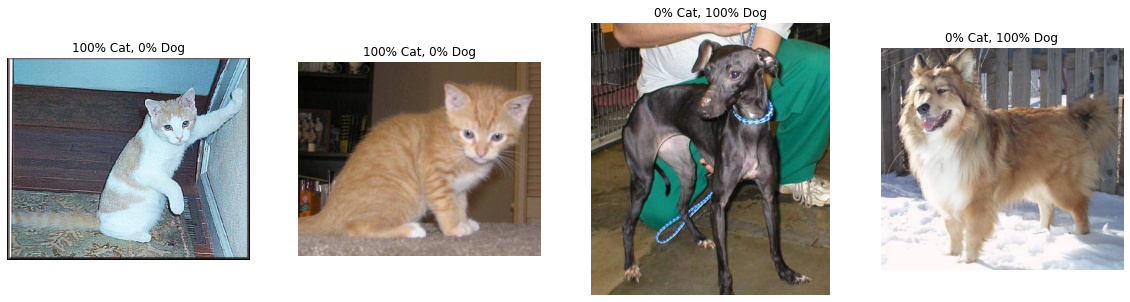

In [44]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Cat, {:.0f}% Dog".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)


In [45]:
labels_input=[]
labels_output=[]
#모델에 validation data를 입력하고 아웃풋으로 preds
def test_model(model, criterion, optimizer, num_epochs=1):
    for phase in ['validation']:
        model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_input.append(labels)

            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            
            labels_output.append(preds)
            
            
test_model(model, criterion, optimizer, num_epochs=1)

In [46]:
y_pred=(torch.cat(labels_output))
y_pred=y_pred.cpu().numpy()


y_true=(torch.cat(labels_input))
y_true=y_true.cpu().numpy()


from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)


array([[ 991,   20],
       [  12, 1000]])